<a href="https://colab.research.google.com/github/BarAvni/deep_learning_2020/blob/master/Homework_1_BarAvniNaor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework #1

1. create a dataloader to load the galaxy10 dataset
2. build a classifier with a fully connceted neural network 
3. write a function to compute the classification accuracy of the network prediction
3. write a training loop and train the model
4. save the loss and accuracy for both the training dataset and the validation dataset after every epoch
5. plot the loss and accuracy
6. save the trained model and model source code (in a .py file)
7. email the trained model to jonathan.shlomi@weizmann.ac.il

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [0]:
!wget -cq https://www.dropbox.com/s/r85ccs17j13rzd0/Dataset.zip?dl=0
!unzip -qq Dataset.zip?dl=0

In [0]:
path_to_training_data = 'Dataset/train/'
path_to_validation_data = 'Dataset/validation/'

### The galaxy10 dataset

in this homework you will build a classifier for the galaxy10 dataset (https://astronn.readthedocs.io/en/latest/galaxy10.html)

but its a "special" version of the dataset created for this homework. The images have been converted to grayscale, and saved as png files in two directories, "train" and "validation". There is a seperate test dataset in a secret location, you will train a model, submit it, and we will evaluate it on the test dataset

you can submit the model once you have over 65% accuracy on the validation dataset. 


### DataLoader:

In [0]:
#first we get a list of the files in the directory

import glob
#glob gives you a list of file paths to the images
filelist = glob.glob(path_to_training_data+'/*.png')

#lets print the first 10 entries:
filelist[:10]

['Dataset/train/class1_1435.png',
 'Dataset/train/class4_2936.png',
 'Dataset/train/class1_9802.png',
 'Dataset/train/class1_8821.png',
 'Dataset/train/class4_4736.png',
 'Dataset/train/class7_6589.png',
 'Dataset/train/class4_5579.png',
 'Dataset/train/class4_2760.png',
 'Dataset/train/class0_8574.png',
 'Dataset/train/class2_727.png']

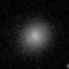

In [0]:
#to load a single image, use the PIL (python image library) function Image
from PIL import Image

Image.open(filelist[0])

In [0]:
#we want to turn it into a pytorch tensor, 
#and flatten it (since we want to train a fully connceted network)
from torchvision import datasets, transforms

img = Image.open(filelist[0])

transforms.ToTensor()( img ).view(-1)

tensor([0.0196, 0.0196, 0.0039,  ..., 0.0549, 0.0902, 0.1294])

In [0]:
## we want to normalize our inputs, to have mean pixel value of 0 and standard deviation 1
import numpy as np


lots_of_images = np.concatenate( [transforms.ToTensor()(Image.open(x)).view(-1) for x in filelist[:1000]] )
print(np.mean(lots_of_images),np.std(lots_of_images))

0.09507928 0.12774989


In [0]:
#to determine the class label of an image, just look at its name:

filelist[:5]

['Dataset/train/class1_1435.png',
 'Dataset/train/class4_2936.png',
 'Dataset/train/class1_9802.png',
 'Dataset/train/class1_8821.png',
 'Dataset/train/class4_4736.png']

In [0]:
## we generate numerical labels based on the file name
import torch

labels = np.zeros(len(filelist))

for class_i in range(10):
    labels[ np.array(['class'+str(class_i) in x for x in filelist]) ] = class_i
    
#the labels need to be converted to torch.LongTensor for multi-class classification
#see the documentation at https://pytorch.org/docs/stable/nn.html#crossentropyloss
labels = torch.LongTensor(labels)

labels

tensor([1, 4, 1,  ..., 2, 7, 1])

## now, write a custom dataloader for the dataset 
remember to flatten the image to a vector of length 69*69

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

class CustomDataset(Dataset):
  # Characterizes a dataset for PyTorch
    def __init__(self, path,mean=0.092,std=0.127,n_classes=10,transform=False):
        
        self.do_transform = transform
        self.mean = mean
        self.std = std

        
        self.filelist = glob.glob(path+'/*.png') # How to get a list of files in a directory
        self.labels = np.zeros(len(self.filelist))
        for class_i in range(10): # How to get the class label from the image file name
            self.labels[ np.array(['class'+str(class_i) in x for x in self.filelist]) ] = class_i
        self.labels = torch.LongTensor(self.labels) # The labels need to be torch.LongTensor
        
    def __len__(self):
      #  Denote the total number of samples
        return len(self.filelist)


    def __getitem__(self, idx):
        # Generates one sample of data
        # Select sample and load it 
        img = Image.open(self.filelist[idx]) # How to load a .png file to PIL
        if self.do_transform:
          img = transforms.RandomRotation(180)( img )
        x = transforms.ToTensor()( img ).view(-1) # How to transform PIL image to torch tensor
        
        x = (x-self.mean)/self.std # How to normalize the data
        
        y = self.labels[idx]
    
        return x, y

## you should get something that works like this:

In [0]:
training_ds = CustomDataset(path_to_training_data,transform=True)
validation_ds = CustomDataset(path_to_validation_data)

In [0]:
some_random_idx = 52
training_ds[some_random_idx]

(tensor([-0.6935, -0.6009, -0.5700,  ..., -0.6935, -0.5700, -0.5083]),
 tensor(2))

In [0]:
## lets also go ahead and create the data loaders,
## and set the batch size
training_dataloader = DataLoader(training_ds,batch_size=120)
valid_dataloader = DataLoader(validation_ds,batch_size=120)

## lets plot some examples from each class

this should work if your dataloader is implemented properly

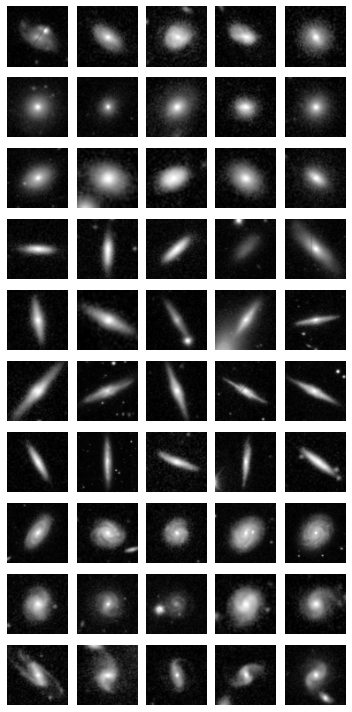

In [0]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(10,5,figsize=(5,10))


for class_i in range(10):
    idxs = np.where( training_ds.labels == class_i )[0]
    idxs = np.random.permutation(idxs)
    for plot_i in range(np.min([5,len(idxs)])):

        ax[class_i][plot_i].imshow(training_ds[idxs[plot_i]][0].reshape(69,69),cmap='gray')
        ax[class_i][plot_i].set_axis_off()
        
plt.tight_layout()
plt.show()

# Now lets build the neural network

its a classifier - it takes as input 69*69 numbers, and outputs 10 numbers

In [0]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.layer1 = nn.Linear(69*69,512)
        self.layer2 = nn.Linear(512,512)
        self.layer3 = nn.Linear(512,512)
        self.layer4 = nn.Linear(512,10)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)
    
    def forward(self,x):
        # flatten image input
        x = x.view(-1,69*69)
        # add hidden layer, with relu activation function
        out = F.relu(self.layer1(x))
        # add dropout layer
        out = self.droput(out)
        out = F.relu(self.layer2(out))
        out = F.relu(self.layer3(out))
        out = self.droput(out)
        out = self.layer4(out)

        return out

In [0]:
## create the instance 

net = Net()

In [0]:
if torch.cuda.is_available():
    net.cuda()

In [0]:
# Loss function 
loss_func = nn.CrossEntropyLoss()

## We want to create a function that will compute the loss and accuracy at the end of each epoch

since this is a small dataset, we don't have a memory constraint and its easy to evaluate on the whole dataset at once

In [0]:
tranining_tensor = torch.stack([training_ds[i][0] for i in range(len(training_ds)) ])
training_labels = training_ds.labels.data.numpy()

validation_tensor = torch.stack([validation_ds[i][0] for i in range(len(validation_ds)) ])
validation_labels = validation_ds.labels.data.numpy()

In [0]:
tranining_tensor.shape

torch.Size([10000, 4761])

In [0]:
training_labels.shape # be careful. Should be (10000,1) dimantions!!!

(10000,)

accuracy is defined as the number of correctly classifier samples out of the whole dataset

In [0]:
def dataset_accuracy(tensor_dataset,targets,net,loss_func):

    net.eval() 

    output = net(tensor_dataset.cuda())
    
    loss = loss_func(output,torch.LongTensor(targets).cuda()) # torch.LongTensor(targets) convert the (10000,) to (10000,1)
 
    output = output.cpu().data.numpy()
    prediction = np.argmax(output,axis=1)

    n_correct = len(np.where(targets==prediction)[0])
    n_total = len(targets)

    return n_correct/n_total, loss.item()

In [0]:
dataset_accuracy(tranining_tensor,training_labels, net, loss_func)

(0.6635, 0.9832724332809448)

In [0]:
# Stochastic gradient descent optimaizer with learning rate of 0.01
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01) 

## Training part

In [0]:
import  torch
from torch.utils import data
from tqdm.notebook import tqdm

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True
# number of epoches to train the model 
n_epochs = 100
# Initialsize tracker for minimum validation loss 
valid_loss_min = np.Inf

loss_vs_epoch = []
accuracy_vs_epoch = []

# Loop over the epochs: 
for epoch in tqdm( range(n_epochs) ):
    ##  Training ## 
    net.train() # prep model for training 
    for x,y in training_dataloader:
      data, target = x.to(device), torch.LongTensor(y).to(device)
      # Clear the gradients for all optimized variables 
      optimizer.zero_grad()
      # Farward pass: compute predicted outputs ny passing inputs to the model 
      pred = net(data)
      # Loss calculation 
      loss = loss_func(pred,target) # torch.LongTensor(targets) convert the (10000,) to (10000,1)
      # Backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # Model weight modification based on the optimizer 
      optimizer.step()
    ## Validation ##       
    net.eval() # evaluation mode - use the function above for each epoch 
    for x,y in valid_dataloader:
      data, target = x.to(device), torch.LongTensor(y).to(device)
      # Farward pass: compute predicted outputs ny passing inputs to the model 
      pred = net(data)
      # Loss calculation 
      loss = loss_func(pred,target) # torch.LongTensor(target) convert the (n,) to n,1)

    training_accuracy, training_loss = dataset_accuracy(tranining_tensor,training_labels, net, loss_func)
    validation_accuracy, validation_loss = dataset_accuracy(validation_tensor,validation_labels, net, loss_func)
    


    loss_vs_epoch.append([training_loss, validation_loss])
    
    accuracy_vs_epoch.append([training_accuracy, validation_accuracy])

    # Save model of Validation loss has decreased
    if validation_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, validation_loss))
      torch.save(net.state_dict(), 'model.pt')
      valid_loss_min = validation_loss


cuda:0


Validation loss decreased (inf --> 0.851651). Saving model ...
Validation loss decreased (0.851651 --> 0.802863). Saving model ...
Validation loss decreased (0.802863 --> 0.762380). Saving model ...
Validation loss decreased (0.762380 --> 0.762186). Saving model ...
Validation loss decreased (0.762186 --> 0.755163). Saving model ...
Validation loss decreased (0.755163 --> 0.751974). Saving model ...
Validation loss decreased (0.751974 --> 0.745499). Saving model ...
Validation loss decreased (0.745499 --> 0.733306). Saving model ...
Validation loss decreased (0.733306 --> 0.716913). Saving model ...
Validation loss decreased (0.716913 --> 0.714848). Saving model ...
Validation loss decreased (0.714848 --> 0.714023). Saving model ...
Validation loss decreased (0.714023 --> 0.696496). Saving model ...
Validation loss decreased (0.696496 --> 0.695528). Saving model ...
Validation loss decreased (0.695528 --> 0.693012). Saving model ...
Validation loss decreased (0.693012 --> 0.689993). Sa

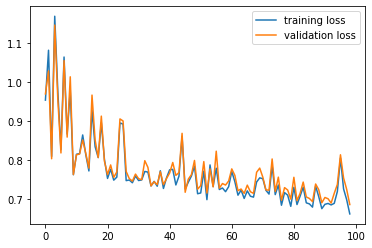

In [0]:
loss_vs_epoch = np.array(loss_vs_epoch)

plt.plot(loss_vs_epoch[:,0][1:],label='training loss')
plt.plot(loss_vs_epoch[:,1][1:],label='validation loss')

plt.legend()

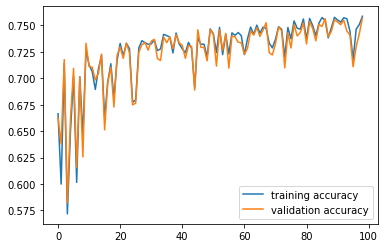

In [0]:
accuracy_vs_epoch = np.array(accuracy_vs_epoch)

plt.plot(accuracy_vs_epoch[:,0][1:],label='training accuracy')
plt.plot(accuracy_vs_epoch[:,1][1:],label='validation accuracy')

plt.legend()

In [0]:
max(accuracy_vs_epoch, key=lambda x:x[1])

array([0.7586, 0.7568])

## save your model

In [0]:
torch.save(net.state_dict(), 'model.pt')

## Bonus round: data augmentation

implement this random rotation into your dataset object - but add an optional input argument to your dataset __init__ so that you can turn this on/off (only use data augmentation for the training dataset)

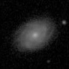

In [0]:
Image.open(filelist[1242])

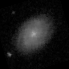

In [0]:
transforms.RandomRotation(180)( Image.open(filelist[1242]) )